# GENERAL NOTES FOR THE WRITE UP SECTIONS
- Method Challenges
    - BaseballReference.com only allows 20 queries per minute, so early on we frequently encountered timeout errors that delayed us significantly. Further, our workarounds for these timeouts caused our code to run extremely slowly
    - Team names changing from prior years
    - couldn’t use individual player data because 1) wouldn’t be able to account for players that got traded midseason and 2) very few baseball players individually impact a team’s playoff success siginficantly
- Initially wanted to use regressor, but couldn’t because Playoff Round is technically a qualitative variable and even when we quantified it, it was discrete, not continuous. Therefore, we had to use classifiers
- Building off of this, we wanted to use raw stats to predict playoff success, but figured that to account for stat differences/trends over the seasons (i.e., the number of HRs in the MLB per season has increased significantly since 2000), we should transform each stat into seasonal rankings to make each value relative to other teams in that particular season
- When ran random forests on all pitching and batting stats, we found the most impactful statistics were all batting metrics. Surprisingly, no pitching statistics had a meaningful impact on playoff performance.
- Initially we just wanted to see if we could predict World Series winners, but then we decided to expand to predicting general playoff success
- Accuracy data skewed high because more than 50% of teams don’t make the playoffs each year, meaning the majority of values in the Playoff Round column are 0, which makes predicting teams that don’t make the playoffs easy. These predictions were included in the accuracy scores, so we believe the ability to predict 
    - To account for this, a step we took was to slice the dataframe to remove all list items (actual and prediction) that were 0, representing teams that didn’t make playoffs, and then recomputing the accuracy score based on those
- we used single-fold CV because of how large our data set was
- we found no features had a significantly larger impact on playoff success than others.
    - every random forest iteration returned different stats as the most impactful variables, none of which ever had an MSE reduction greater than 0.006 when looking at all statistics together
    - when we ran decision trees on all the stats together and then on various smaller groupings of stats, the accuracy scores were always similar regardless of stats used
- one difficulty the decision tree classifier model seemed to have was due to the fact that most teams don’t make the playoffs, so it would predict 0 (didn't make playoffs) most of the time. To adjust for this, we filtered the master_df to only include rows of teams/seasons that made the playoffs


## Abstract

## Introduction
When the Major League Baseball playoffs come around every October, predictions and bets about which team will win the World Series intensify. While there are always differing opinions, the unbiased consensus regarding the favorite is almost always the team with the highest regular season win total. However, this prediction is usually wrong - the winningest regular season team has only won the World Series 4 times in the last 30 seasons (excludes the 1994 season that had no World Series due to a players strike). Further, a 2022 Elder Research study found that teams' perceived skill levels ("power ratings") correctly predicted ~56% of regular season winners in simulations but only ~31% of World Series winners. This 25% discrepancy is the largest of the 4 major professional sports organizations in America (MLB, National Football League, National Basketball Association, National Hockey League), and means having such a long regular season (162 games) does not necessarily translate to more predictable World Series winners.

This raises some questions regarding World Series predictions:
- Why is regular season wins such a poor predictor of World Series champion? Is it primarily due to level of randomness in team performances in each individual game, the format of the playoffs, or other factors?
- Do any overall team statistics, have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

[Elder Research Report](https://www.elderresearch.com/blog/how-often-does-the-best-team-win-the-title/#:~:text=The%20MLB's%20best%20team%2C%20on,the%20best%20regular%20season%20team)

### Usage of Data

After cleaning and visualizing the data, I will use the data to try to answer the questions posed above. Although we have only just begun covering machine learning models in class, I have prior experience with some ML methods and see a few paths for learning and predicting on this data.
- I might begin by running several random forests, each on different groups of statistics (i.e., single season team statistics, single season player statistics for the top players on teams' rosters, etc.) to see which metrics, if any, appear to have a noticeable correlation with World Series winners and playoff performance. I could also run similar ML models to see which factors influence regular season performance the most, and compare these findings.
- After determining which factors might be more correlated with playoff performance and regular season performance, I could run linear regressions on regular season performance versus playoff performance. Then, I would turn this into a multiple regression model and perform trial and error by introducing various additional factors into the model.

## Method
NOTES FOR GUIDANCE:
- EXPLAIN THAT WE USED RANDOM FOREST CLASSIFIER TO DETERMINE FEATURE IMPORTANCE AND THEN DECISION TREE CLASSIFIER TO PREDICT PLAYOFF OUTCOMES.


## Results

## Discussion


# **Data and Analysis Plan: World Series Predictions**

- Justin Radist
- Suneet Pathangay
- Zhenzhen Liu
- Elijah Sandler

## Project Goal:

Our project aims to explore the relationship between various MLB team and individual player statistics and the performance of teams in the playoffs and World Series. We have chosen to focus on common batting and pitching statistics for teams and individual players over the last 25-30 years. We may also focus on other pieces of data such as payrolls, team injuries, fan base support and stadium dimensions. Specifically, we ask:
- What metrics - whether they be certain team statistics, individual player statistics, injuries, payrolls, fan bases, stadiums, etc. - have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

We are using https://www.baseball-reference.com/ for our main data source, which we will webscrape from. We are not using any API.

## Pipeline Overview:

We have already written several functions for scraping the Baseball Reference website:
- build_player_url() and build_team_url()
    - Builds the URLs needed to access a certain player's or team's statistics page.
- get_batting_df() & get_pitching_df(()
    - Get tables of a team's batting and pitching statistics, respectively, for a given season.
- get_season_batting_df()
    - Get batting stats by team for a given season. We'll add a get_season_pitching_df(season) function soon.
- get_player_df()
     - Along with get_player_dict(), builds dataframes of a player's common careers stats table.

### Pipeline:

#### 1. Building URLs and Webscraping

In [1]:
# import statements
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from bs4 import Comment
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import tree
from copy import copy

In [3]:
def build_team_url(team, year):
    """ Constructs the URL of any MLB team's Baseball Reference stat page for a single season
    
    Args:
        team (str): 3-letter abbreviation of one of the 30 current MLB teams in existence
        year (int): the year/season to get team data for
    
    Returns:
        url (str): the URL that can be used to retrieve the given team's
        stats for the given year from BaseballReference.com
    """
    url = f"https://www.baseball-reference.com/teams/{team}/{str(year)}.shtml"
    return url

In [4]:
# testing cell
team = 'NYM'
season = '2022'
team_url = build_team_url(team, season)

In [6]:
# testing cell
team_soup = get_soup(team_url)
time.sleep(4)

#### 2. Cleaning Data and Building Dataframes

In [5]:
dict_team_batting = defaultdict(lambda: dict())
def get_batting_df(team_code, dict_team_batting=dict_team_batting, year=2023):
    """ Gets the batting table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by Baseball Reference
        dict_team_batting (dict): dictionary containing all queries we've made before
        year(int): the year we want data from, defaults to 2023

    Returns:
        dict_team_batting[year][team_code] (pd.DataFrame): dataframe of batting stats for given team and year
    """
    
    if team_code in dict_team_batting.keys():
        return dict_team_batting[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_batting = pd.read_html(url)[0]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_batting.index:
            try:
                int(df_batting.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_batting.loc[idx, :]], axis=1)
            except(ValueError):
                pass
        
        dict_team_batting[year][team_code] = df_filtered.T
        
    return dict_team_batting[year][team_code]

In [8]:
# testing cell
get_batting_df('NYY')

,Rk,Pos,Name,Age,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,C,Kyle Higashioka,33,92,260,242,24,57,13,...,.274,.413,.687,85,100,5,0,1,3,0
1,2,1B,Anthony Rizzo*,33,99,421,373,45,91,14,...,.328,.378,.706,94,141,10,12,0,1,1
2,3,2B,Gleyber Torres,26,158,672,596,90,163,28,...,.347,.453,.800,118,270,19,3,0,6,0
3,4,SS,Anthony Volpe,22,159,601,541,62,113,23,...,.283,.383,.666,81,207,10,5,1,2,0
4,5,3B,DJ LeMahieu,34,136,562,497,55,121,22,...,.327,.390,.718,96,194,14,3,0,2,2
5,6,LF,Oswaldo Cabrera#,24,115,330,298,35,63,11,...,.275,.299,.574,58,89,6,2,3,2,1
6,7,CF,Harrison Bader,29,84,310,288,40,69,11,...,.278,.365,.643,75,105,6,3,1,4,0
7,8,RF,Aaron Judge,31,106,458,367,79,98,16,...,.406,.613,1.019,175,225,5,0,0,3,9
8,9,DH,Giancarlo Stanton,33,101,415,371,43,71,13,...,.275,.420,.695,87,156,11,2,0,1,3
10,10,UT,Isiah Kiner-Falefa,28,113,361,326,39,79,12,...,.306,.340,.646,78,111,12,3,1,3,0


In [6]:
dict_team_pitching = defaultdict(lambda: dict())
def get_pitching_df(team_code, dict_team_pitching=dict_team_pitching, year=2023):
    """ Gets the pitching table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by baseball reference
        dict_team_pitching (dict): dictionary containing all queries we've made before
        year(int): year we want data from, defaults to 2023
    Returns:
        dict_team_pitching[year][team_code] (pd.DataFrame): dataframe of pitching stats for given team and year
    """
    
    if team_code in dict_team_pitching[year].keys():
        return dict_team_pitching[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_pitching = pd.read_html(url)[1]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_pitching.index:
            try:
                int(df_pitching.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_pitching.loc[idx, :]], axis=1)
            except(ValueError):
                pass
          
        dict_team_pitching[year][team_code] = df_filtered.T
        
    return dict_team_pitching[year][team_code]

In [10]:
# testing cell
get_pitching_df('BOS')

,Rk,Pos,Name,Age,W,L,W-L%,ERA,G,GS,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,1,SP,Brayan Bello,24,12,11,.522,4.24,28,28,...,1,668,107,4.54,1.338,9.5,1.4,2.6,7.6,2.93
1,2,SP,Kutter Crawford,27,6,8,.429,4.04,31,23,...,4,527,113,3.83,1.106,7.4,1.2,2.5,9.4,3.75
2,3,SP,Tanner Houck,27,6,10,.375,5.01,21,21,...,1,463,91,4.43,1.368,8.8,1.2,3.5,8.4,2.41
3,4,SP,Chris Sale*,34,6,5,.545,4.30,20,20,...,3,425,106,3.80,1.130,7.6,1.3,2.5,11.0,4.31
4,5,SP,James Paxton*,34,7,5,.583,4.50,19,19,...,5,411,101,4.68,1.313,8.7,1.7,3.1,9.5,3.06
6,6,CL,Kenley Jansen,35,3,6,.333,3.63,51,0,...,1,188,126,3.66,1.276,8.1,1.0,3.4,10.5,3.06
7,7,RP,Josh Winckowski,25,4,4,.500,2.88,60,1,...,2,367,158,3.91,1.423,9.5,1.0,3.3,8.8,2.65
8,8,RP,Chris Martin,37,4,1,.800,1.05,55,0,...,1,199,434,2.44,1.032,7.9,0.4,1.4,8.1,5.75
9,9,RP,Brennan Bernardino*,31,2,1,.667,3.20,55,6,...,3,216,143,3.41,1.303,8.5,0.7,3.2,10.3,3.22
10,10,RP,John Schreiber,29,2,1,.667,3.86,46,2,...,1,204,118,4.52,1.414,7.9,1.2,4.8,10.2,2.12


In [75]:
# currently only used for a data analysis plan graph
def get_season_batting_df(season):
    """ Gets a table of common batting stats organized by MLB team for a given season
    Args:
        season (int): the season to get data for
    
    Returns:
         df_season_batting (pd.DataFrame): a dataframe of batting stats by team for a season
    """
    url = f'https://www.baseball-reference.com/leagues/majors/{season}.shtml'
    
    df_season_batting = pd.read_html(url)[0]
    time.sleep(4)
    
    return df_season_batting

In [10]:
team_abbrevs_dict = {'Arizona Diamondbacks': 'ARI',
                     'Atlanta Braves': 'ATL',
                     'Baltimore Orioles': 'BAL',
                     'Boston Red Sox': 'BOS',
                     'Chicago Cubs': 'CHC',
                     'Chicago White Sox': 'CWS',
                     'Cincinnati Reds': 'CIN',
                     'Cleveland Guardians': 'CLE',
                     'Colorado Rockies': 'COL',
                     'Detroit Tigers': 'DET',
                     'Houston Astros': 'HOU',
                     'Kansas City Royals': 'KAN',
                     'Los Angeles Angels': 'LAA',
                     'Los Angeles Dodgers': 'LAD',
                     'Miami Marlins': 'MIA',
                     'Milwaukee Brewers': 'MIL',
                     'Minnesota Twins': 'MIN',
                     'New York Mets': 'NYM',
                     'New York Yankees': 'NYY',
                     'Oakland Athletics': 'OAK',
                     'Philadelphia Phillies': 'PHI',
                     'Pittsburgh Pirates': 'PIT',
                     'San Diego Padres': 'SDP',
                     'San Francisco Giants': 'SFG',
                     'Seattle Mariners': 'SEA',
                     'St. Louis Cardinals': 'STL',
                     'Tampa Bay Rays': 'TBR',
                     'Texas Rangers': 'TEX',
                     'Toronto Blue Jays': 'TOR',
                     'Washington Nationals': 'WAS'}

## Visualizations:

This visualization plots how many World Series winners led the league in each stat during the regular season of the year they won the World Series.

In [78]:
# get the World Series information
table = pd.read_html("https://www.baseball-reference.com/postseason/world-series.shtml")
time.sleep(4)
ws_data = table[0]

# rename win and win1 to AL Wins and NL Wins
ws_data.rename(columns={ws_data.columns[2]: 'AL Wins'}, inplace=True)
ws_data.rename(columns={ws_data.columns[3]: 'NL Wins'}, inplace=True)

In [79]:
# build dictionary of World Series winners
ws_winner_dict = {}

for idx, row in ws_data.iterrows():
    if row['AL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['AL Winner']
    if row['NL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['NL Winner']

In [4]:
def seasonal_data(year):
    """ gets team batting and pitching data for a given season
    
    Args: 
        year (int): year of statistics
        
    Returns: 
        batting (df): dataframe of batting statistics
        pitching (df): dataframe of pitching statistics
    """
    
    url = f'https://www.baseball-reference.com/leagues/majors/{str(year)}.shtml'
    batting = pd.read_html(url)[0]
    # convert all values in table to float (except for team names)
    batting = pd.concat([batting.iloc[:30, 0], batting.iloc[:30, 1:].astype(float)], axis=1)
    
    """ for whatever reason, the html for the pitching table is commented out.
        so, we have to go in with bs4, find the tables in the comments, and then read that html. """
    
    response = requests.get(url)
    html_content = response.content

    # use bs4 to parse the HTML, including comments
    soup = BeautifulSoup(html_content, 'html.parser')

    # find all HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    # extract tables from comments
    tables = []
    for comment in comments:
        comment_soup = BeautifulSoup(str(comment), 'html.parser')
        comment_tables = comment_soup.find_all('table')
        tables.extend(comment_tables) # not append

    pitching = pd.read_html(str(tables[1]))[0]
    # convert all values in table to float (except for team names)
    pitching = pd.concat([pitching.iloc[:30, 0], pitching.iloc[:30, 1:].astype(float)], axis=1)
    
    # clean tables
    batting_filtered = pd.DataFrame()
    for idx in batting.index:
        try:
            int(batting.loc[idx, '#Bat'])
            batting_filtered = pd.concat([batting_filtered, batting.loc[idx, :]], axis=1)
        except(ValueError):
            pass
        
    pitching_filtered = pd.DataFrame()
    for idx in pitching.index:
        try:
            int(pitching.loc[idx, '#P'])
            pitching_filtered = pd.concat([pitching_filtered, pitching.loc[idx, :]], axis=1)
        except(ValueError):
            pass
    
    # don't get timed out
    time.sleep(8.2)
    
    return batting, pitching
    #return batting_filtered.T, pitching_filtered.T

In [90]:
# testing cell
b, p = seasonal_data(2023)
p.head()

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,...,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB
0,Arizona Diamondbacks,34.0,28.5,4.70,84.0,78.0,0.519,4.47,162.0,162.0,...,6100.0,98.0,4.35,1.324,8.6,1.2,3.3,8.5,2.57,1050.0
1,Atlanta Braves,32.0,29.9,4.42,104.0,58.0,0.642,4.14,162.0,162.0,...,6135.0,108.0,4.10,1.302,8.4,1.2,3.3,9.5,2.84,1112.0
2,Baltimore Orioles,31.0,28.4,4.19,101.0,61.0,0.623,3.89,162.0,162.0,...,6098.0,106.0,3.98,1.243,8.3,1.1,2.9,8.9,3.03,1080.0
3,Boston Red Sox,33.0,30.0,4.79,78.0,84.0,0.481,4.52,162.0,162.0,...,6168.0,101.0,4.37,1.338,8.9,1.3,3.1,9.0,2.86,1117.0
4,Chicago Cubs,27.0,29.6,4.46,83.0,79.0,0.512,4.08,162.0,162.0,...,6085.0,110.0,4.16,1.283,8.3,1.1,3.2,8.6,2.68,1073.0


In [92]:
year = 2023
b, p = seasonal_data(2023)

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [273]:
# DO NOT RUN THIS CELL AGAIN UNTIL WE SUBMIT!!! READ IN "master_df.csv" CSV FILE INSTEAD
# master stat table with batting, pitching, and playoff success data for every team each of last 25 seasons
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
master_df = pd.DataFrame()

for year in years:
    # get batting and pitching tables by team for current season
    b, p = seasonal_data(year)
    # combine batting and pitching dfs for 1 season into 1 df
    current_year_df = pd.concat([b, p], axis=1)
    current_year_list = pd.Series(map(lambda x: year, range(len(b))), name='Season')
    # add column identifying what season the current data is from
    current_year_df = pd.concat([current_year_list.to_frame(), current_year_df], axis=1)
    # add column of teams' playoff success
    playoff_col = playoff_success_df.loc[year].reset_index(drop=True)
    playoff_col = pd.Series(playoff_col, name='Playoff Round')
    current_year_df = pd.concat([current_year_df, playoff_col.to_frame()], axis=1)
    # add current year's df to master df
    master_df = pd.concat([master_df, current_year_df])

# save master_df to a CSV file
master_df.to_csv('master_df.csv', index=False)

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [254]:
master_df_read = pd.read_csv('master_df.csv')

In [255]:
# removes uninformative stats from dataframe 
master_df_read.drop(['#Bat', 'G', 'PA', 'AB', '#P', 'Tm.1', 'G.1', 'BF'], axis=1, inplace=True)

In [285]:
# turn all values in master_df_read into ranks, where ranks are all seasonal
low_is_better_stats = ['BatAge', 'CS', 'SO', 'GDP', 'LOB', 'PAge', 'RA/G', 'L', 'ERA', 'H.1', 'R.1', 'ER', 'HR.1',
                      'BB.1', 'IBB.1', 'HBP.1', 'BK', 'WP', 'WHIP', 'H9', 'HR9', 'BB9']

master_df_ranked = master_df_read[['Season', 'Tm']]
for col in list(master_df_read.columns)[2:-1]:
    col_rank = []
    for season in range(len(master_df_read['Season'].unique())):
        seasonal_df = master_df_read.iloc[season*30:season*30+30]
        if col in low_is_better_stats:
            temp_ranks = seasonal_df[col].rank(method='min')
        else:
            temp_ranks = seasonal_df[col].rank(ascending=False, method='min')
        for temp_rank in temp_ranks:
            col_rank.append(temp_rank)
    col_rank_series = pd.Series(col_rank, name=col)
    master_df_ranked = pd.concat([master_df_ranked, col_rank_series.to_frame()], axis=1)
master_df_ranked = pd.concat([master_df_ranked, master_df_read['Playoff Round'].to_frame()], axis=1)

In [330]:
# filter master_df_read and master_df_ranked for only rows of teams/seasons that made the playoffs
master_df_read_playoffs = master_df_read[master_df_read['Playoff Round'] != 0]
master_df_ranked_playoffs = master_df_read[master_df_ranked['Playoff Round'] != 0]

In [16]:
def rf_classifier(df, x_feat_list, y=None, max_depth=4, n_splits=6, cross_val=False):
    """ build a Random Forest Classifier model
    
    Args: 
        df (pd.DataFrame): dataframe to run
        x_feat_list (list): list of columns in df being used to predict the y feature
        y (str): column in df to predict
        max_depth (int): maximum depth each decision tree in the random forest should go
        cross_val (bool): if True, model should be cross validated
        n_splits (int): if model is meant to be cross validated, this
        is how many times to split the data when cross validating
    Returns:
        rf_class (RandomForestClassifier): a random forest classifier model
    """
    
    # default x_feat_list, features to predict stats upon
    if x_feat_list is None:
        x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP', 'SO9']
    
    # default y, feature to estimate
    if y is None:
        y = 'Playoff Round'

    # get columns of the features being used to predict playoff outcome
    x = df[x_feat_list].values

    # get column of feature being estimated
    y_true = df[y].values

    # initialize a rf_classifier with a max depth of 3
    rf_class = RandomForestClassifier(n_estimators=100, max_depth=max_depth)

    if cross_val == False:
        rf_class.fit(x, y_true)
        # predict y (from classifier)
        y_pred = rf_class.predict(x)
        return rf_class
    
    # construction of kfold object with n folds
    kfold = KFold(n_splits=n_splits)

    # allocate an empty array to store predictions in
    y_pred = copy(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # modify rf_classifier internal state to remember all training samples
        rf_class.fit(x_train, y_true_train)

        # estimate each team's playoff outcome (round they make it to)
        y_pred[test_idx] = rf_class.predict(x_test)
    
    #return y_true, y_pred
    return rf_class

In [367]:
def plot_feat_import(feat_list, feat_import, show=True, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        show (bool): if True, shows the bar graph of important features
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value
    
    Returns:
        feat_list (list): the n number of stats with the highest Gini values, where n=limit
    """
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx]
        #print(feat_import)
        #print(idx)
        
    if limit is not None:
        # limit to the first limit feature
        #feat_list = feat_list[:limit]
        #feat_import = feat_import[:limit]
        feat_list = feat_list[-limit:]
        feat_import = feat_import[-limit:]
    
    if show == True:
        # plot and label feature importance
        plt.barh(feat_list, feat_import)
        plt.gcf().set_size_inches(5, len(feat_list) / 2)
        plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')
        plt.show()
    return feat_list

In [331]:
# run rf classifier on raw master df and ranked master df
x_feat_list = list(master_df_read.columns)[2:-1]
rf_clf = rf_classifier(master_df_read, x_feat_list, y='Playoff Round', cross_val=True)
rf_clf_ranked = rf_classifier(master_df_ranked, x_feat_list, y='Playoff Round', cross_val=True)

In [334]:
# run rf classifier on playoff team-only versions of raw master df and ranked master df
rf_clf_playoffs = rf_classifier(master_df_read_playoffs, x_feat_list, y='Playoff Round', cross_val=True)
rf_clf_ranked_playoffs = rf_classifier(master_df_ranked_playoffs, x_feat_list, y='Playoff Round', cross_val=True)

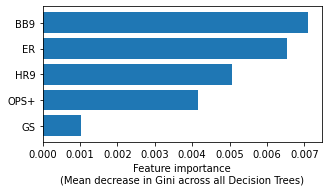

['GS', 'OPS+', 'HR9', 'ER', 'BB9']

In [355]:
# show rf classifier results
plot_feat_import(x_feat_list, rf_clf_playoffs.feature_importances_, limit=5)

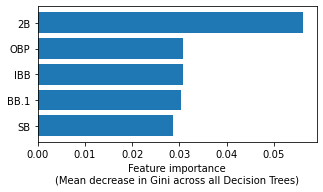

['SB', 'BB.1', 'IBB', 'OBP', '2B']

In [379]:
rf_clf_ranked_playoffs = rf_classifier(master_df_ranked_playoffs, x_feat_list, y='Playoff Round', cross_val=True)
plot_feat_import(x_feat_list, rf_clf_ranked_playoffs.feature_importances_, limit=5)

In [373]:
feat_import_counts = {}
for i in range(50):
    rf_clf_ranked_playoffs = rf_classifier(master_df_ranked_playoffs,
                                           x_feat_list,
                                           cross_val=True)
    temp_import_feats = plot_feat_import(x_feat_list,
                                         rf_clf_ranked_playoffs.feature_importances_,
                                         show=False,
                                         limit=5)
    for feat in temp_import_feats:
        if feat in feat_import_counts.keys():
            feat_import_counts[feat] += 1
        else:
            feat_import_counts[feat] = 1

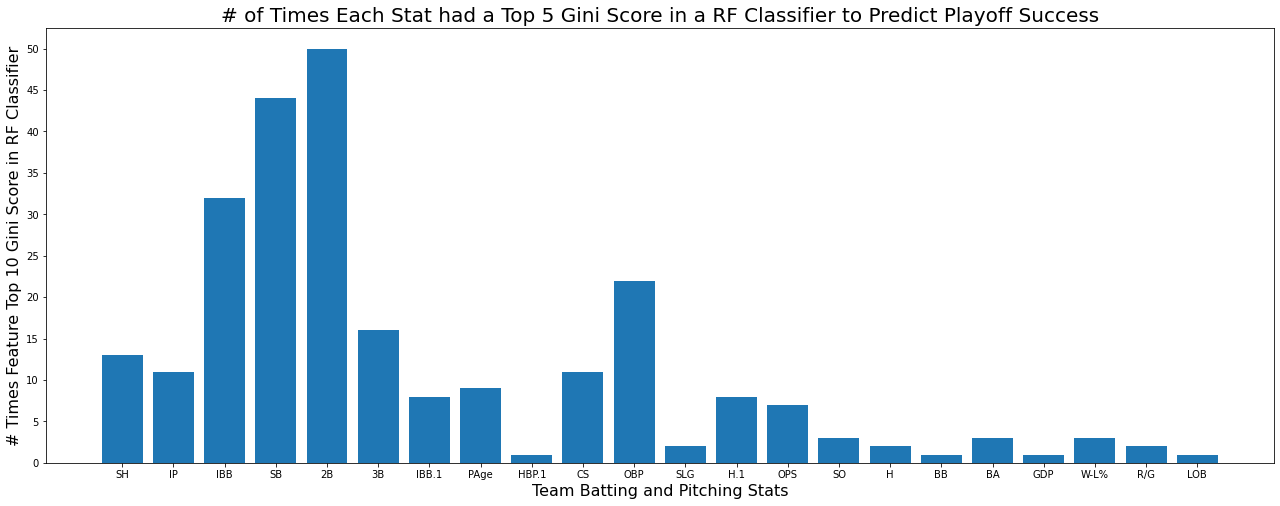

In [442]:
plt.bar(feat_import_counts.keys(), feat_import_counts.values())
plt.yticks(list(range(0, 55, 5)))

plt.xlabel('Team Batting and Pitching Stats', fontsize=16)
plt.ylabel('# Times Feature Top 10 Gini Score in RF Classifier', fontsize=16)
plt.title('# of Times Each Stat had a Top 5 Gini Score in a RF Classifier to Predict Playoff Success',
          fontsize=20)
plt.gcf().set_size_inches(22, 8)
plt.show()

In [221]:
# CLASSIFIER CODE
# returns percent of predictions that are accurate (as a decimal)
accuracy_score(y_true_clf, y_pred_clf)

0.5666666666666667

In [13]:
def ws_winner_leading_data(team, year, num_teams=1):
    """ Get regular season stat leading data from a World Series winner
        
    Args:
        team (string): the name of the team
        year (int or string): the year that the team won the World Series
        num_teams (int): the lowest rank in the MLB a World Series winner can be in a stat to be considered a
        "leader" in that stat category (e.g., if num_teams is 3, then a World Series winner must have had one of
        the 3 highest stat values of any team in the MLB that season to be considered a "leader")
        
    Returns:
        None
    """
    # get table of aggregated batting data by team for a single season
    batting_table, _ = seasonal_data(year)
    time.sleep(4)
    
    batting_table.drop('G', axis=1, inplace=True)
    
    # loop through all stats in table
    for stat in list(batting_table.columns[3:]):
        # for each stat, convert its column of values to a list and sort in descending order
        stat_list = list(batting_table[stat])
        stat_list.sort(reverse=True)
        # find the cutoff stat value
        cutoff = stat_list[num_teams - 1]
        
        # if WS winner met/exceeded cutoff stat value, add 1 to the dict count of the current stat
        if (batting_table[batting_table[stat] >= cutoff]['Tm'] == team).any():
            if stat in stat_counts_dict.keys():
                stat_counts_dict[stat] += 1
            else:
                stat_counts_dict[stat] = 1
        
    return None

In [ ]:
# dictionary of counts of last 25 WS winners that were top 3 in the MLB in each batting stat
stat_counts_dict = {}
year_count = 0
for year, team in ws_winner_dict.items():
    if year_count > 25:
        break
    ws_winner_leading_data(team, year, num_teams=3)
    year_count += 1

stat_counts_dict

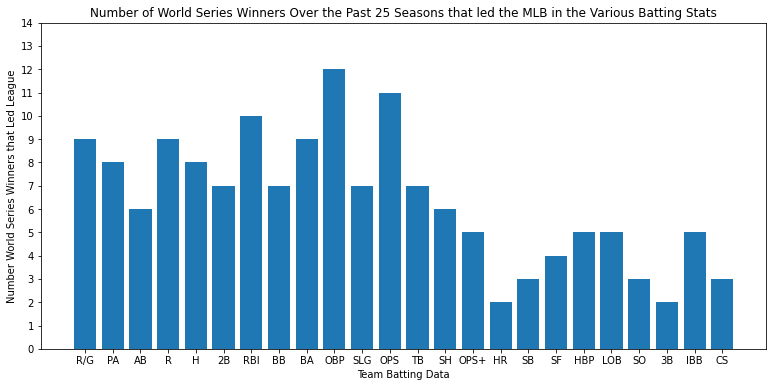

In [31]:
# create bar chart of stats and how often World Series winners led the league in them
plt.bar(stat_counts_dict.keys(), stat_counts_dict.values())
plt.yticks(list(range(15)))

plt.xlabel('Team Batting Data')
plt.ylabel('Number World Series Winners that Led League')
plt.title('Number of World Series Winners Over the Past 25 Seasons that led the MLB in the Various Batting Stats')
plt.gcf().set_size_inches(13, 6)
plt.show()

In [33]:
playoff_data = pd.read_html('https://www.baseball-reference.com/postseason/')[0]

In [34]:
# rename columns
playoff_data.rename(columns={playoff_data.columns[1]: 'Series Outcome'}, inplace=True)
playoff_data.rename(columns={playoff_data.columns[2]: 'Matchup'}, inplace=True)

In [35]:
year = 2023
temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
temp_slice.iloc[0:3, 2].str.count('Texas Rangers').sum()

2

In [36]:
# get playoff success for all teams for the past 25 seasons
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
year_success = []
playoff_success_df = pd.DataFrame()

for year in years:
    temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
    year_success = []
    for team in team_abbrevs_dict.keys():
        # check if team won World Series
        if ws_winner_dict[int(year)] == team:
            year_success.append(5)
        # if team didn't win World Series, check if they made it to World Series
        elif team in temp_slice.iloc[0,2]:
        #elif team in temp_slice['Matchup'][0]:
            year_success.append(4)
        # if team didn't make it to World Series, check if they made it to Championship Series (CS)
        elif temp_slice.iloc[1:3, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][1:3].str.count(team).sum() > 0:
            year_success.append(3)
        # if team didn't make it to CS, check if they made it to Division Series (DS)
        elif temp_slice.iloc[3:7, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][3:7].str.count(team).sum() > 0:
            year_success.append(2)
        # if team didn't make it to DS, check if they made it to Wild Card (WC) round
        elif temp_slice.iloc[7:, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][7:].str.count(team).sum() > 0:
            year_success.append(1)
        # if team didn't make playoffs, append 0
        else:
            year_success.append(0)

    year_series = pd.Series(year_success)
    playoff_success_df = pd.concat([playoff_success_df, year_series.to_frame().T])

# make df rows the seasons, make columns the teams/abbrevs, cells all contain 0, 1, 2, 3, 4, or 5
playoff_success_df.columns = list(team_abbrevs_dict.values())
playoff_success_df.index = years

In [527]:
test = pd.DataFrame(playoff_success_df.loc[2023])
team_data_2023 = seasonal_data(2023)

In [487]:
def train_dec_tree(df, year, feature_list):
    """ trains a decision tree to predict teams' Playoff Rounds using batting and/or pitching stats
    
    Args:
        df (pd.DataFrame): df to train decision tree on
        year (int): season to make predictions for
        feature_list (list): stats to train decision tree with to predict Playoff Round
    
    Returns:
        predicted_playoff_round_dict (dict): keys are teams, values are predicted Playoff Round
        accuracy (float): the cross validated accuracy score of the decision tree
    """
    predicted_playoff_round_dict = {}
    
    # runs until only 1 team is predicted to win WS, not 0 or 2+
    while list(predicted_playoff_round_dict.values()).count(5) != 1:
        predicted_playoff_round_dict = {}
    
        # Filter data for the specified year
        train_data = df[(df['Season'] != year)]

        # x features being used to predict target, which is 'Playoff Round'
        features_train = train_data[feature_list]
        target_train = train_data['Playoff Round']

        # split training data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(features_train, target_train, test_size=0.3)#, random_state=42)

        # Initialize the decision tree classifier
        clf = DecisionTreeClassifier()#(random_state=42)

        # Train the classifier on the training data
        clf.fit(X_train, y_train)

        # Make predictions on the validation set
        predictions_val = clf.predict(X_val)

        # Get a list of all teams for prediction
        teams_to_predict = df[df['Season'] == year]['Tm']

        # build dictionary of playoff predictions
        for team in teams_to_predict:
            team_features = df[(df['Season'] == year) & (df['Tm'] == team)][feature_list]
            predicted_playoff_round = clf.predict(team_features)
            predicted_playoff_round_dict[team] = predicted_playoff_round[0]
        
    # compute model accuracy on validation set
    accuracy = accuracy_score(y_val, predictions_val)
            
    return predicted_playoff_round_dict, accuracy

In [617]:
# alt to above: testing if can CV w/out splitting into train and test 2x over 
def train_dec_tree(df, year, feature_list):
    predicted_playoff_round_dict = {}
    
    # runs until only 1 team is predicted to win WS, not 0 or 2+
    while list(predicted_playoff_round_dict.values()).count(5) != 1:
        predicted_playoff_round_dict = {}
    
        # Filter data for the specified year
        train_data = df[(df['Season'] != year)]
        test_data = df[(df['Season'] == year)]

        # split training data into training and validation sets
        x_train = train_data[feature_list]
        x_test = test_data[feature_list]
        y_train = train_data['Playoff Round']
        y_test = test_data['Playoff Round']

        # Initialize the decision tree classifier
        clf = DecisionTreeClassifier()

        # Train the classifier on the training data
        clf.fit(x_train, y_train)

        # Make predictions on the validation set
        y_pred = clf.predict(x_test)

        # get list of all teams
        teams = df[df['Season'] == year]['Tm']

        # build dict of playoff predictions (only include teams that actually made the playoffs)
        for idx, row in df[df['Season'] == year].iterrows():
            #if row[-1] != 0:
                #predicted_playoff_round_dict[row[1]] = y_pred[idx]
            predicted_playoff_round_dict[row[1]] = y_pred[idx - (30 * (2023 - year))]
    
    # compute model accuracy on validation set
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, predicted_playoff_round_dict, accuracy

In [620]:
# testing my alt dec tree function above that doesn't split into train and test data 2x over
x_feat_list = list(master_df_ranked_playoffs.columns)[2:-1]
for year in range(1999, 2024):
    y_pred, playoff_predict_dict, accuracy = train_dec_tree(master_df_ranked, year, x_feat_list)
    for team in playoff_predict_dict.keys():
        if playoff_predict_dict[team] == 5:
            if team == ws_winner_dict[year]:
                print('CORRECT WS PREDICTION')
                correct_count += 1
    print(year)
    print(playoff_predict_dict)
    print(accuracy)
    #print(f'Decision Tree WS Champion Prediction Accuracy: {round(correct_count / 25, 2)}')

1999
{'Anaheim Angels': 4, 'Arizona Diamondbacks': 2, 'Atlanta Braves': 0, 'Baltimore Orioles': 5, 'Boston Red Sox': 0, 'Chicago Cubs': 0, 'Chicago White Sox': 0, 'Cincinnati Reds': 2, 'Cleveland Indians': 0, 'Colorado Rockies': 0, 'Detroit Tigers': 0, 'Florida Marlins': 0, 'Houston Astros': 4, 'Kansas City Royals': 0, 'Los Angeles Dodgers': 0, 'Milwaukee Brewers': 0, 'Minnesota Twins': 0, 'Montreal Expos': 2, 'New York Mets': 1, 'New York Yankees': 3, 'Oakland Athletics': 1, 'Philadelphia Phillies': 0, 'Pittsburgh Pirates': 0, 'San Diego Padres': 0, 'Seattle Mariners': 0, 'San Francisco Giants': 1, 'St. Louis Cardinals': 0, 'Tampa Bay Devil Rays': 0, 'Texas Rangers': 2, 'Toronto Blue Jays': 0}
0.5666666666666667
2000
{'Anaheim Angels': 0, 'Arizona Diamondbacks': 1, 'Atlanta Braves': 0, 'Baltimore Orioles': 0, 'Boston Red Sox': 0, 'Chicago Cubs': 0, 'Chicago White Sox': 4, 'Cincinnati Reds': 0, 'Cleveland Indians': 3, 'Colorado Rockies': 2, 'Detroit Tigers': 0, 'Florida Marlins': 0, 'H

2011
{'Arizona Diamondbacks': 2, 'Atlanta Braves': 0, 'Baltimore Orioles': 0, 'Boston Red Sox': 5, 'Chicago Cubs': 0, 'Chicago White Sox': 0, 'Cincinnati Reds': 0, 'Cleveland Indians': 0, 'Colorado Rockies': 0, 'Detroit Tigers': 2, 'Florida Marlins': 0, 'Houston Astros': 0, 'Kansas City Royals': 0, 'Los Angeles Angels of Anaheim': 0, 'Los Angeles Dodgers': 0, 'Milwaukee Brewers': 1, 'Minnesota Twins': 0, 'New York Mets': 0, 'New York Yankees': 3, 'Oakland Athletics': 0, 'Philadelphia Phillies': 2, 'Pittsburgh Pirates': 0, 'San Diego Padres': 0, 'Seattle Mariners': 0, 'San Francisco Giants': 1, 'St. Louis Cardinals': 1, 'Tampa Bay Rays': 2, 'Texas Rangers': 4, 'Toronto Blue Jays': 0, 'Washington Nationals': 0}
0.8
2012
{'Arizona Diamondbacks': 0, 'Atlanta Braves': 1, 'Baltimore Orioles': 1, 'Boston Red Sox': 0, 'Chicago Cubs': 0, 'Chicago White Sox': 0, 'Cincinnati Reds': 0, 'Cleveland Indians': 3, 'Colorado Rockies': 0, 'Detroit Tigers': 5, 'Houston Astros': 0, 'Kansas City Royals': 0,

KeyboardInterrupt: 

In [34]:
def predict_playoff_outcome(df, x_stat_list=None, y=None, max_depth=4, plot=True, cross_val=False):
    if x_stat_list is None:
        x_stat_list = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP', 'SO9']
    if y is None:
        y = 'Playoff Round'
    
    y = df[y].values
    x = df[x_stat_list].values
    
    # set up the array of predictions to fill out
    y_pred = np.empty(len(x))

    # split data into training and testing sets to perform leave-one-out cross validation
    Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf = dec_tree_clf.fit(Xtrain, ytrain)
    
    # predict data on test set
    y_pred = dec_tree_clf.predict(Xtest)
    
    # compute accuracy score
    accuracy = accuracy_score(ytest, y_pred)
    
    return ytest, y_pred, accuracy

In [35]:
def remove_nonplayoff_teams(y_true, y_pred):
    """ removes all 0s from an array of team playoff outcomes and predicted playoff outcomes so the only data
        remaining in the datasets are instances of teams that did make the playoffs.
    
    Args:
        y_true (np.array): quantified playoff success data 
        y_pred (np.array): quantified predictions of playoff success for the y_true dataset
    
    Returns:
        y_true, y_pred (tup): both original arrays with the elements of y_true that were 0 removed and the
        elements in the equivalent indexes of y_pred removed
    """
    
    idx = 0
    while idx < len(y_true):
        if y_true[idx] == 0:
            y_true = np.delete(y_true, idx)
            y_pred = np.delete(y_pred, idx)
        else:
            idx += 1
    
    return y_true, y_pred

In [444]:
# this code is same as code below (or above) but runs decision trees on all 25 seasons multiple times over
total_accuracy = 0
num_dec_trees = 10
for i in range(num_dec_trees):
    correct_count = 0
    for year in range(1999, 2024):
        #x_feat_list = ['2B', 'SB', 'IBB', 'OBP']
        x_feat_list = list(master_df_ranked_playoffs.columns)[2:-1]
        playoff_predict_dict, accuracy = train_dec_tree(master_df_ranked_playoffs, year, x_feat_list)
        for team in playoff_predict_dict.keys():
            if playoff_predict_dict[team] == 5:
                if team == ws_winner_dict[year]:
                    correct_count += 1
                break
    total_accuracy += correct_count / 25
avg_accuracy = round(total_accuracy / num_dec_trees, 2)
print(f'Average WS Champion Prediction Accuracy Over {count} Decision Tree Iterations: {avg_accuracy}')

Average WS Champion Prediction Accuracy Over 1 Decision Tree Iterations: 0.09


In [ ]:
accuracy_dict = {}
total_acc = 0
avg_acc = 0
x_feats_batting = ['BatAge', 'R/G', 'H', 'HR', 'RBI', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+']
for x_feat in x_feats_batting:
    total_acc = 0
    for year in range(1999, 2024):
        playoff_predict_dict, accuracy = train_dec_tree(master_df_ranked_playoffs, year, [x_feat])
        total_acc += accuracy
    avg_acc = total_acc / 10
    accuracy_dict[x_feat] = accuracy
accuracy_dict

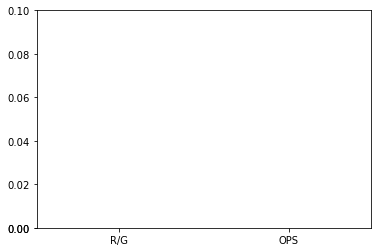

In [468]:
plt.bar(accuracy_dict.keys(), accuracy_dict.values())
plt.yticks([0, 0.00, 0.02, 0.04, 0.06, 0.08, 0.1])
plt.ylim(0, 0.1)
plt.show()

In [ ]:
# run decision trees for stats inidividually, then plots WS champion prediction accuracy results by stat
total_accuracy = 0
accuracy_dict = {}
x_feat_list = master_df_ranked_playoffs.columns[2:-1]
x_feat_list_batting = master_df_ranked_playoffs.columns[2:26]
x_feat_list_pitching = master_df_ranked_playoffs.columns[26:-1]
#x_feats_batting = ['BatAge', 'R/G', 'H', '2B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+','LOB']
x_feats_batting = ['H', 'HR', 'BA', 'OPS']
#x_feats_batting = ['BatAge', 'R/G', 'H', 'HR', 'RBI', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+']
x_feats_pitching = ['PAge', 'RA/G', 'W-L%', 'ERA', 'SV', 'H.1', 'R.1', 'ER', 'HR.1', 'BB.1', 'SO.1', 'ERA+',
                    'FIP', 'WHIP']
for x_feat in x_feats_batting:
    correct_count = 0
    for year in range(1999, 2024):
        playoff_predict_dict = train_dec_tree(master_df_ranked_playoffs, year, [x_feat])
        for team in playoff_predict_dict.keys():
            if playoff_predict_dict[team] == 5:
                if team == ws_winner_dict[year]:
                    correct_count += 1
                break
    total_accuracy += correct_count / 25
    accuracy_dict[x_feat] = round(total_accuracy, 2)
    print(accuracy_dict)
plt.bar(accuracy_dict.keys(), accuracy_dict.values())


In [439]:
# this code is same as code below (or above) but runs decision trees on all 25 seasons multiple times over
total_accuracy = 0
num_dec_trees = 10
for i in range(num_dec_trees):
    correct_count = 0
    for year in range(1999, 2024):
        x_feat_list = ['2B']
        playoff_predict_dict = train_dec_tree(master_df_ranked_playoffs, year, features_to_use)
        for team in playoff_predict_dict.keys():
            if playoff_predict_dict[team] == 5:
                if team == ws_winner_dict[year]:
                    correct_count += 1
    total_accuracy += correct_count / 25
avg_accuracy = round(total_accuracy / num_dec_trees, 2)
print(f'Average WS Champion Prediction Accuracy Over {count} Decision Tree Iterations: {avg_accuracy}')

Average WS Champion Prediction Accuracy Over 1 Decision Tree Iterations: 0.18


In [428]:
correct_count = 0
for year in range(1999, 2024):
    #x_feat_list = ['2B', 'SB', 'IBB', 'OBP']
    x_feat_list = list(master_df_ranked_playoffs.columns)[2:-1]
    playoff_predict_dict = train_dec_tree(master_df_ranked_playoffs, year, features_to_use)
    for team in playoff_predict_dict.keys():
        if playoff_predict_dict[team] == 5:
            #print(f'Predicted {year} World Series champion: {team}')
            if team == ws_winner_dict[year]:
                print('CORRECT PREDICTION')
                correct_count += 1
print(f'Decision Tree WS Champion Prediction Accuracy: {round(correct_count / 25, 2)}')

Accuracy on the validation set: 0.18
Predicted 1999 World Series champion: New York Mets
Accuracy on the validation set: 0.28
Predicted 2000 World Series champion: New York Mets
Accuracy on the validation set: 0.25
Predicted 2001 World Series champion: San Francisco Giants
Accuracy on the validation set: 0.26
Predicted 2002 World Series champion: Anaheim Angels
CORRECT PREDICTION
Accuracy on the validation set: 0.31
Predicted 2003 World Series champion: New York Mets
Accuracy on the validation set: 0.40
Predicted 2004 World Series champion: New York Mets
Accuracy on the validation set: 0.25
Predicted 2005 World Series champion: Florida Marlins
Accuracy on the validation set: 0.29
Predicted 2006 World Series champion: Los Angeles Angels of Anaheim
Accuracy on the validation set: 0.45
Predicted 2007 World Series champion: Arizona Diamondbacks
Accuracy on the validation set: 0.29
Predicted 2008 World Series champion: Boston Red Sox
Accuracy on the validation set: 0.23
Predicted 2009 World

In [ ]:
x_stat_list_spec = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP', 'SO9']
x_stat_list_gen = list(master_df_read.columns)[2:-1]
y_test_gen, y_pred_gen, accuracy_gen = predict_playoff_outcome(master_df_read, x_stat_list_gen)
y_test_spec, y_pred_spec, accuracy_spec = predict_playoff_outcome(master_df_read, x_stat_list_spec)
y_true_filt, y_pred_filt = remove_nonplayoff_teams(y_test_spec, y_pred_spec)
print(y_test_gen)
print(y_pred_gen)

In [ ]:
predict_playoff_outcome(master_df_read)

As you can see in the graph above, for every batting stat, at most 3 of the last 10 World Series winners led the league in it the year they won. This is actually a greater percentage than the number of teams that led the MLB in regular season wins the year they won the World Series, which is somewhat promising for our project. One next step could be to expand from only counting World Series winners that led the entire MLB in a stat to counting World Series winners that were one of the top 3 or 5 teams in the MLB for a stat that season. This is likely to increase the counts substantially while still providing relevant info, since top 5 out of 30 teams in still in the highest quintile.

The visualization below displays scatter plots with 2 sets of data points on the each plot: 1 color for the mean values by season, a different color for the set of values for World Series winners by season. We are looking to see if World Series winners consistently had well-above average values for any stat, which would indicate there might be some relationship between that stat and playoff success.

In [81]:
seasons = []
batting_stats = {'H': [],
                'HR': [],
                'RBI': [],
                'BA': [],
                'OPS': []}

# loop backwards through the past n seasons
for i in range(10):
    season = 2023 - i
    seasons.append(season)
    # pull df for current loop's season, set team name as the index
    df_season_batting = get_season_batting_df(season).set_index('Tm')
    time.sleep(4)
    # loop through all the stats in the dictionary initialized above
    for stat in list(batting_stats.keys()):
        # get the average team value for the current stat in the current season
        avg_stat_val = df_season_batting[stat][:30].astype(float).mean()
        
        # get the value for the current stat for the team that won the World Series in the current loop's season
        ws_winner = ws_winner_dict[season]
        ws_winner_stat_val = float(df_season_batting.loc[ws_winner][stat])
        
        # create 2-item list of mean stat value and World Series winner stat value for the current season
        temp_stat_list = [round(avg_stat_val, 3), round(ws_winner_stat_val, 3)]
        # add the 2-item list to list of the respective stat in the batting stats dictionary
        batting_stats[stat].append(temp_stat_list)

In [ ]:
# plot mean team and WS winner values for each stat by season
sns.set_style('darkgrid')
for stat, values in batting_stats.items():
    temp_array = np.array(values)
    plt.scatter(seasons, temp_array[:, 0], label='Mean Value')
    plt.scatter(seasons, temp_array[:, 1], label='WS Winner Value')
    plt.xticks(seasons)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel('Season')
    plt.ylabel(stat.capitalize())
    plt.title(f'Mean and WS Winner {stat.capitalize()} Values by Season')
    plt.show()

Almost all World Series winners have been above average in each of the above 5 batting statistics over the last 10 seasons. This supports our conclusions from the first visualization, which is that World Series winners perform well in these categories and that they may be better at predicting playoff success than regular season wins. Another next step will be to look at pitching stats in this same manner.

## Analysis/ML Plan:

The model that we feel that will be most appropriate for this would be a multi variate regression model to calculate the playoff performance and the chance of a team winning the World Series. Further more, we would figure out which which metrics are the greatest predictors of World Series winners. We can investigate linear regression with variety of inputs and predictors such as individual player statistics,payrolls,and injuries to see if we can accuractely predict whether a team will win the World Series. All of these factors could definitely play a roll in our model, however the one that stands out the most would probably be player statistics. Some player statistics that could have a huge impact woould be important stats such as batting average. It would also be important to consider other forms of regresison such as polynomial regresison. In conclusion, we will probably ending using a multi variate regression model to calculate playoff performances.

However, we recognize that playoff performance is a qualitative data point (i.e., "won World Series," "lost in NLCS," etc.), and while it can be quantified (e.g., made playoffs = 1, won Wild Card round = 2, ..., won World Series = 5), there's only a few possible outcomes, which may make regression difficult to implement usefully. Therefore, we expect we might need to switch to more qualitative ML models such as multivariate perceptrons, decision trees, random forests, etc. to get higher utility results. For instance, we might use a team's batting average, OPS, pitching staff ERA, and pitching staff WHIP to predict whether a team will make it to the playoffs - if they do, then predict whether a team will win the Wild Card round ... - until eventually, the remaining teams will be used to predict which will win the World Series.  